In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [3]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [4]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [5]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [6]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 10
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(X.shape[0] / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size]

            outputs = self.Bert(**inputs_batch)
            outputs = outputs['pooler_output'].detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [7]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#Read the data

In [9]:
df = pd.read_csv('../data/bbc-text.csv')

In [10]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [11]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [12]:
df2 = pd.get_dummies(df, columns=['category'])

In [13]:
X = df2['text']

In [14]:
Y = df2.drop(columns=['text'])

In [15]:
#Test data anonymized
df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')

In [16]:
df.head()

,Unnamed: 0,CRMIncidentId,IncidentId,LineId,Linje,JourneyId,TurNummer,Trafikslag,Ankomstdag,Händelsedatum,...,Enhet,Queue_SK,Kö,ModifiedOn,ContactId,Contact_SK,iBID,IsActive,TicketId,Beskrivning_Anonymized
0,0,673326,77DE23B5-43D8-E811-80F6-005056B63599,-1,NaN,-1,NaN,NaN,2018-10-25,NaN,...,Kundtjänst,8,Support Synpunkter,2018-10-29 11:33:19,586769,C0BDFF48-2C0B-E811-80F1-005056B64D75,NaN,True,NaN,"Hej,\r\n \r\nHar nu fått tag i föraren som är ..."
1,1,673354,EBD68435-41D8-E811-80F6-005056B63599,-1,NaN,-1,NaN,NaN,2018-10-25,NaN,...,Kundtjänst,8,Support Synpunkter,2018-11-08 08:17:09,331145,E429FD9A-5DEC-E411-80D6-0050569071BE,NaN,True,NaN,Buss 000 00:00\r\n\r\nKristianstad Hästtorget ...
2,2,673617,3ED0AA37-16D9-E811-80F4-005056B62B18,-1,NaN,-1,NaN,NaN,2018-10-26,NaN,...,Kundtjänst,8,Support Synpunkter,2021-10-07 08:49:10,726145,12F4B35F-16D9-E811-80F4-005056B62B18,NaN,True,NaN,Skadeanmälan för påkörning av bil bakifrån vid...
3,3,673807,AAA91AC9-E0D8-E811-80F5-005056B64D75,-1,NaN,-1,NaN,NaN,2018-10-26,NaN,...,Kundtjänst,8,Support Synpunkter,2018-11-08 10:36:12,603794,56A30A33-A32D-E811-80F2-005056B62B18,NaN,True,NaN,"Hej, \r\nVarför heter en av hållplatserna i Lu..."
4,4,673850,5F1165E6-63D9-E811-80F5-005056B64D75,-1,NaN,-1,NaN,NaN,2018-10-26,NaN,...,Kundtjänst,8,Support Synpunkter,2019-11-27 15:06:13,22229,383EAEB1-1DEB-E411-80D8-005056903A38,NaN,True,NaN,Hej!\r\nHar en fråga som gäller busskurerna i ...


In [17]:
df.columns

Index(['Unnamed: 0', 'CRMIncidentId', 'IncidentId', 'LineId', 'Linje',
       'JourneyId', 'TurNummer', 'Trafikslag', 'Ankomstdag', 'Händelsedatum',
       'Hanteratdatum', 'Ärendenummer', 'KategoriId11', 'Kategori11',
       'KategoriId12', 'Kategori12', 'KategoriId13', 'Kategori13',
       'KategoriId21', 'Kategori21', 'KategoriId22', 'Kategori22',
       'KategoriId23', 'Kategori23', 'KategoriId31', 'Kategori31',
       'KategoriId32', 'Kategori32', 'KategoriId33', 'Kategori33',
       'KategoriId41', 'Kategori41', 'KategoriId42', 'Kategori42',
       'KategoriId43', 'Kategori43', 'Titel', 'CaseType_SK', 'Ärendetyp',
       'CaseOrigin_SK', 'Ursprung', 'Priority_SK', 'Prioritet',
       'IncidentStage_SK', 'ÄrendeStatus', 'Owner_SK', 'Handläggare',
       'BusinessUnit_SK', 'Enhet', 'Queue_SK', 'Kö', 'ModifiedOn', 'ContactId',
       'Contact_SK', 'iBID', 'IsActive', 'TicketId', 'Beskrivning_Anonymized'],
      dtype='object')

(array([320., 383.,   0.,  10.,   0., 228.,  54.,   0.,   2.,   4.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

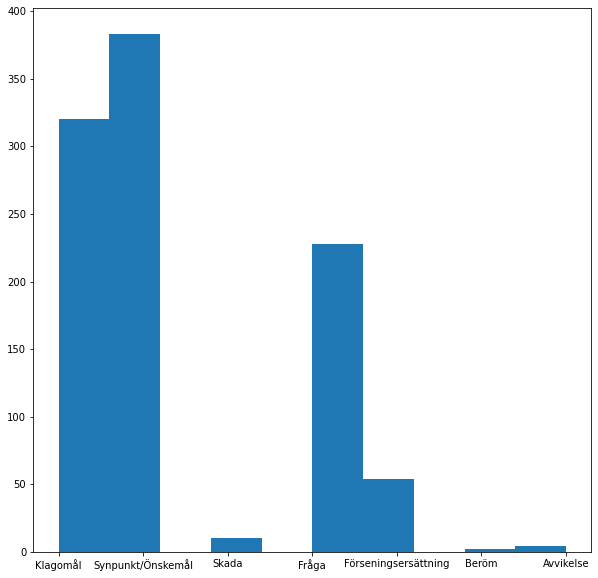

In [18]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [19]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary

In [20]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])

In [21]:
X.head()

0    hej,\r\n \r\nhar nu fått tag i föraren som är ...
1    buss 000 00:00\r\n\r\nkristianstad hästtorget ...
2    skadeanmälan för påkörning av bil bakifrån vid...
3    hej, \r\nvarför heter en av hållplatserna i lu...
4    hej!\r\nhar en fråga som gäller busskurerna i ...
Name: Beskrivning_Anonymized, dtype: object

In [22]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [23]:
Y.head()

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [24]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [25]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
X_train.shape

(800,)

In [28]:
Y_train[:5]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
535,0,0,0,0,0,0,1
696,0,0,1,0,0,0,0
557,0,0,0,0,0,0,1
643,0,0,1,0,0,0,0
597,0,0,0,0,0,0,1


In [29]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100, max_epochs=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.batchId = 0
        self.epochId = 0
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1
            print(self.batchId, self.epochId)
            print(len(X_mini))
            if len(X_mini) < self.batch_size:
                self.epochId += 1
                self.batchId = 0
                if self.epochId <= self.max_epochs:
                    print('will break')
                    break
            
            yield X_mini, Y_mini
            


In [30]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [73]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch

In [74]:
output.predict(X_test[:10])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0]], dtype=uint8)

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
521,0,0,1,0,0,0,0
941,0,0,0,0,0,0,1
741,0,0,1,0,0,0,0
980,0,0,0,0,0,0,1
411,0,0,0,0,0,0,1
679,0,0,1,0,0,0,0
673,0,0,0,0,0,0,1
513,0,0,0,0,1,0,0
773,0,0,0,0,1,0,0
136,0,0,0,0,0,0,1


In [32]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [101]:
result = PredictClasses(pipeline, X[:2])

Transform Called
Running batch 1/1
output shape: (2, 768)
transformed.shape: (2, 768)


In [102]:
result

array([4, 6], dtype=int64)

In [104]:
Y[1:2]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
1,0,0,0,0,0,0,1


In [84]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/21
output shape: (10, 768)
Running batch 2/21
output shape: (10, 768)
Running batch 3/21
output shape: (10, 768)
Running batch 4/21
output shape: (10, 768)
Running batch 5/21
output shape: (10, 768)
Running batch 6/21
output shape: (10, 768)
Running batch 7/21
output shape: (10, 768)
Running batch 8/21
output shape: (10, 768)
Running batch 9/21
output shape: (10, 768)
Running batch 10/21
output shape: (10, 768)
Running batch 11/21
output shape: (10, 768)
Running batch 12/21
output shape: (10, 768)
Running batch 13/21
output shape: (10, 768)
Running batch 14/21
output shape: (10, 768)
Running batch 15/21
output shape: (10, 768)
Running batch 16/21
output shape: (10, 768)
Running batch 17/21
output shape: (10, 768)
Running batch 18/21
output shape: (10, 768)
Running batch 19/21
output shape: (10, 768)
Running batch 20/21
output shape: (10, 768)
Running batch 21/21
output shape: (1, 768)
transformed.shape: (201, 768)


array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [106]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    
    

In [33]:
#Evaluate the model and print the accuracy
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

In [107]:
EvaluateModelUsingProbs(pipeline, X_test, Y_test)

Transform Called
Running batch 1/21
output shape: (10, 768)
Running batch 2/21
output shape: (10, 768)
Running batch 3/21
output shape: (10, 768)
Running batch 4/21
output shape: (10, 768)
Running batch 5/21
output shape: (10, 768)
Running batch 6/21
output shape: (10, 768)
Running batch 7/21
output shape: (10, 768)
Running batch 8/21
output shape: (10, 768)
Running batch 9/21
output shape: (10, 768)
Running batch 10/21
output shape: (10, 768)
Running batch 11/21
output shape: (10, 768)
Running batch 12/21
output shape: (10, 768)
Running batch 13/21
output shape: (10, 768)
Running batch 14/21
output shape: (10, 768)
Running batch 15/21
output shape: (10, 768)
Running batch 16/21
output shape: (10, 768)
Running batch 17/21
output shape: (10, 768)
Running batch 18/21
output shape: (10, 768)
Running batch 19/21
output shape: (10, 768)
Running batch 20/21
output shape: (10, 768)
Running batch 21/21
output shape: (1, 768)
transformed.shape: (201, 768)
Total Accuracy: 0.48258706467661694


In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [130]:
y.iloc[0:10].values

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [140]:
#Save, Load model

In [2]:
from joblib import dump, load

In [15]:
modelName = 'BertModel.joblib'

In [142]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [52]:
from torch import nn, optim
import torch.nn.functional as F

class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),              
                          nn.Linear(64, n_classes),
                          nn.Softmax(dim=1))
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        print('Forward Called')
       
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X

In [53]:
torchModel = TorchNLP(n_classes = Y.shape[1])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [33]:
output = torchModel(X_train[:5])

Forward Called


In [34]:
output

tensor([[0.1392, 0.1366, 0.1573, 0.1440, 0.1380, 0.1289, 0.1559],
        [0.1413, 0.1344, 0.1574, 0.1403, 0.1445, 0.1316, 0.1505],
        [0.1382, 0.1305, 0.1564, 0.1452, 0.1477, 0.1298, 0.1523],
        [0.1465, 0.1331, 0.1607, 0.1391, 0.1349, 0.1371, 0.1486],
        [0.1406, 0.1333, 0.1514, 0.1402, 0.1429, 0.1266, 0.1650]],
       grad_fn=<SoftmaxBackward0>)

In [57]:
mMiniBatcherTrain = MiniBatcher(X_train[:100], Y_train[:100], batch_size=5)
mMiniBatcherTest = MiniBatcher(X_test[:25], Y_test[:25], batch_size=5)

In [48]:
torchModel.Bert.parameters()

<generator object Module.parameters at 0x000002C2318596D0>

In [54]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torchModel.parameters(), lr=0.003)

epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        print('Training batch...')
        optimizer.zero_grad()
        labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
        print('Running torch')
        output = torchModel(images)
        print('Calculating loss')
        loss = criterion(output, labels)
        print('Back prop.')
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
   
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            print('Validation batch...')
            labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            output = torchModel(images)
            test_loss += criterion(output, labels)

            top_p, top_class = output.topk(1, dim=1)
            print(top_p)
            top_p_target, top_class_target = labels.topk(1, dim=1)
            equals = top_class == top_class_target
            #equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(mMiniBatcherTest.X)))

1 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
2 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
3 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
4 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
5 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
6 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
7 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
8 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
9 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
10 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
11 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
12 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
13 0
5
Training batch...


Calculating loss
Back prop.
14 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
15 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
16 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
17 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
18 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
19 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
20 0
5
Training batch...
Running torch
Forward Called
Calculating loss
Back prop.
21 0
0
will break
1 0
5
Validation batch...
Forward Called
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])
2 0
5
Validation batch...
Forward Called
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])
3 0
5
Validation batch...
Forward Called
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
   

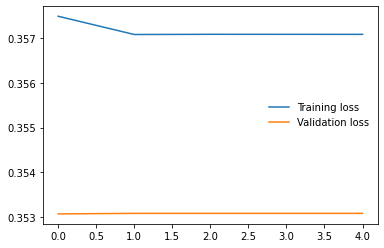

In [59]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)